In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 22 07:05:30 2017

@author: angusurquhart
Extract meta data from trackobot
--still to do
--add in rank
--de-duplicate card data
"""
from collections import defaultdict
import trackopy
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
import numpy as np
from sqlalchemy import create_engine
from sklearn.linear_model import LogisticRegression
import random
import datetime as dt

In [2]:
#Setup trackobot
user = {"password":'e479deb2e1', 'username':'still-gnoll-6604'}
trackobot = trackopy.Trackobot(user['username'], user['password'])

In [3]:
#Use this to setup sql imports/exports later
conn_string = "mssql+pymssql://" + '192.168.1.52' + "/" + 'naturex'
engine = create_engine(conn_string)
conn = engine.connect()

In [4]:
#trackobot.history(page=7)

In [7]:
#Put all the pages into a single dictionary
#Note that this is game level data - 'history'
singledict = {}
list_of_game_dicts = []

for x in range(1,25):

     singledict[1] = trackobot.history(page=x)
     list_of_game_dicts.append(singledict.copy())
    
#list_of_game_dicts

In [8]:
#this shows that i can access a single page
#I'll come back to this and loop over it once I have my output ready
page = list_of_game_dicts[5]
#page


In [9]:
#this shows the level at which useful data is containted
#the meta stuff in this case is pretty useless - the real info is in the history.
page[1].keys()

dict_keys(['history', 'meta'])

In [10]:
#This is actually the data we'll want to flatten into a table
#page[1]['history']

In [11]:
#This is digging into the card 
#page[1]['history'][0]['card_history'][-1]['turn']

In [12]:
#This is the id for a single game
page[1]['history'][0]['id']

80816300

In [13]:
#Build a dataframe of page 1 meta info
#df = pd.DataFrame(page[1]['history'], columns=['added','coin', 'duration','hero','hero_deck','id','legend','mode','note','opponent','opponent_deck','rank','result'])
#df.head()

In [14]:
#Create an empty dataframe for all the meta game fields
#TO REFRESH THE DATATABLE START HERE
columns = ['added','coin', 'duration','hero','hero_deck','id','legend','mode',
           'note','opponent','opponent_deck','rank','result', 'card_history']
metatable = pd.DataFrame(columns=columns)
#metatable
metatable.shape

(0, 14)

In [15]:
#I want to figure out how to apply a card level bit of data onto my meta row data
#list_of_game_dicts[0][1]['history']

In [16]:
#This will now loop through and create my meta table
for i in range(len(list_of_game_dicts)):
    metatable = metatable.append(pd.DataFrame(list_of_game_dicts[i][1]['history'], columns=['added','coin', 'duration','hero',
                                                                                        'hero_deck','id','legend','mode','note',
                                                                                        'opponent','opponent_deck','rank','result'
                                                                                           ,'card_history']
                                         ),ignore_index = True)

metatable.shape


(280, 14)

In [17]:
#type(list_of_game_dicts)
list_of_game_dicts[0][1]['history'][2]
#list_of_game_dicts

{'added': '2017-06-25T07:23:50.000Z',
 'card_history': [],
 'coin': True,
 'duration': 26,
 'hero': 'Mage',
 'hero_deck': None,
 'id': 81987629,
 'legend': None,
 'mode': 'ranked',
 'note': None,
 'opponent': 'Priest',
 'opponent_deck': None,
 'rank': None,
 'result': 'win'}

In [18]:
#metatable.dtypes
#I want to create a dataframe of just the information that is relevant to card history
#Create an empty dataframe for all the meta game fields
#TO REFRESH THE DATATABLE START HERE
game_columns = ['id','turn','name', 'player','mana']
game_data = pd.DataFrame(columns=game_columns)
#metatable
game_data.shape



(0, 5)

In [16]:
#I need to figure out how i want to loop through this e.g. within a game and then by game
s2 = pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan], index=['id','turn','name', 'player','mana'])
game_data = game_data.append(s2,ignore_index=True)
#So the 2nd variable loops through a single game
#So how many cards were played in teh first game - i'll need this for my first loop
card_history_only = metatable[metatable['card_history'].map(len) > 0]
#len(card_history_only)

counter = -1
for z in range(len(card_history_only)):
    #loop through a single game
    for i in range(len(card_history_only['card_history'][z])):
        counter = counter +1
        game_data = game_data.append(s2,ignore_index=True)
        game_data.set_value([counter], 'id', card_history_only['id'][z])
        game_data.set_value([counter], 'turn', card_history_only['card_history'][z][i]['turn'])
        game_data.set_value([counter], 'name', card_history_only['card_history'][z][i]['card']['name'])
        game_data.set_value([counter], 'player', card_history_only['card_history'][z][i]['player'])
        game_data.set_value([counter], 'mana', card_history_only['card_history'][z][i]['card']['mana'])
    

#This data will get somewhat duplicated as i store it in sql so i want a date of import added to dataframe
game_data['Import_Date'] = dt.date.today().strftime("%d/%m/%Y")
game_data['Date_Time'] = dt.datetime.today().strftime('%Y-%m-%d %H:%M:%S')
game_data['id'] = game_data['id'].map(lambda x: '{:.0f}'.format(x))
print("finished")

#game_data.head()


finished


In [17]:
#card_history_only
#game_data.head()


In [25]:
game_data.shape

(2663, 7)

In [19]:
#Write card data to sql
conn_string = "mssql+pymssql://" + '192.168.1.52' + "/" + 'naturex'
engine = create_engine(conn_string)
conn = engine.connect()
game_data.to_sql('HS_CardTable', engine, if_exists='append', index=False, schema='dbo')
print("finished")

finished


In [26]:
#I'd like to de-duplicate the data in sql now as there is crossover between each import
#First I need to extract data into a dataframe
sql_extract = pd.read_sql('select [id],[turn], [name], [player], [mana], [import_date],[Date_Time],RANK() over(partition by [id],[turn], [name], [player], [mana] order by Date_Time )Rank From naturex.[dbo].[HS_CardTable] order by id,Date_Time,turn, player', engine)
                          
sql_extract.head()

,id,turn,name,player,mana,import_date,Date_Time,Rank
0,80203851,1,Northshire Cleric,me,1,15/06/2017,2017-06-15 17:50:02,1
1,80203851,2,Faerie Dragon,me,2,15/06/2017,2017-06-15 17:50:02,1
2,80203851,2,Arcanologist,opponent,2,15/06/2017,2017-06-15 17:50:02,1
3,80203851,3,The Coin,me,0,15/06/2017,2017-06-15 17:50:02,1
4,80203851,3,Tortollan Shellraiser,me,4,15/06/2017,2017-06-15 17:50:02,1
5,80203851,3,Fireblast,opponent,2,15/06/2017,2017-06-15 17:50:02,1
6,80203851,4,Twilight Drake,me,4,15/06/2017,2017-06-15 17:50:02,1
7,80203851,4,Arcanologist,opponent,2,15/06/2017,2017-06-15 17:50:02,1
8,80203851,4,Fireblast,opponent,2,15/06/2017,2017-06-15 17:50:02,1
9,80203851,5,Lesser Heal,me,2,15/06/2017,2017-06-15 17:50:02,1


In [20]:
#sql_extract = pd.sql_extract.sort_values([[id],[Date_Time]])
# sql_extract.sort_index(by=['id', 'Weeks'], ascending=[True, False])
#sql_extract = sql_extract.drop_duplicates(cols='A', take_last=True)
#sql_extract = sql_extract.groupby(['Date_Time','turn'], as_index=False).max()

NameError: name 'sql_extract' is not defined

In [35]:
sql_extract

,Date_Time,id,turn,name,player,mana,Import_Date
0,2017-06-15 17:50:02,nan,29,NaN,NaN,10,15/06/2017
1,2017-06-19 09:13:29,nan,29,NaN,NaN,12,19/06/2017


In [21]:
#metatable[metatable['card_history'].map(len) > 0]
#metatable['card_history']

In [19]:
#I want to do some pre-work to tidy up fields for an import into sql
#Alytic doesn't like true false fields so change to text
metatable['coin'] = metatable['coin'].replace(True,'Go First')
metatable['coin'] = metatable['coin'].replace(False,'Go Second')

#I want a field for wins and losses so that I can do wins as a % of total
dummy_result = pd.get_dummies(metatable['result'], prefix='result')
#dummy_result.head()
metatable = pd.concat([metatable, dummy_result], axis=1)



#Add some fields for counting games
metatable['Game Counter/100'] = 0.01
metatable['Game Counter'] = 1

#Convert added field to be DateTime
metatable['DateTime'] = pd.to_datetime(metatable['added'],exact = False)

#Now create useful date fields
metatable['Date'] = metatable['DateTime'].dt.date
metatable['Time'] = metatable['DateTime'].dt.time
metatable['Month'] = metatable['DateTime'].apply(lambda x: x.strftime('%B-%Y'))  
metatable['Hour'] = metatable['DateTime'].dt.hour

#Drop useless columns
metatable = metatable.drop('legend', 1)
metatable = metatable.drop('note', 1)
metatable = metatable.drop('added', 1)
metatable = metatable.drop('card_history', 1)

#Rename some fields, in particular, rank which is used for other commands
metatable = metatable.rename(columns={'rank': 'H_rank'})

metatable.head()
#metatable.dtypes
                       

,coin,duration,hero,hero_deck,id,mode,opponent,opponent_deck,H_rank,result,result_loss,result_win,Game Counter/100,Game Counter,DateTime,Date,Time,Month,Hour
0,Go Second,956,Warlock,Hand,82084566,ranked,Priest,None,NaN,win,0,1,0.01,1,2017-06-26 06:25:14,2017-06-26,06:25:14,June-2017,6
1,Go First,1342,Mage,Secret,81988900,ranked,Priest,None,NaN,win,0,1,0.01,1,2017-06-25 07:46:25,2017-06-25,07:46:25,June-2017,7
2,Go First,26,Mage,None,81987629,ranked,Priest,None,NaN,win,0,1,0.01,1,2017-06-25 07:23:50,2017-06-25,07:23:50,June-2017,7
3,Go Second,504,Mage,Secret,81987578,ranked,Shaman,Midrange,NaN,loss,1,0,0.01,1,2017-06-25 07:23:04,2017-06-25,07:23:04,June-2017,7
4,Go First,255,Paladin,Murloc,81987001,ranked,Warrior,Pirate,NaN,loss,1,0,0.01,1,2017-06-25 07:12:03,2017-06-25,07:12:03,June-2017,7


In [20]:
#USE THIS TO TEST NEW FIELDS TO ADD TO SQL TABLE
#Split up Un'Goro from MSOG
# Set Un-Goro release date
ungoro_date = pd.to_datetime('04-06-2017')
metatable['Expansion'] = np.where(metatable['DateTime']>ungoro_date, 'Un-Goro', 'MSOG')
#metatable[['Expansion','Date','DateTime']]

In [21]:
#I'm not going to add some predictions from a logistic regression model
#First start by formatting fields for modelling

metatable['coin_model'] = metatable['coin']
metatable['result_model'] = metatable['result']

metatable['coin_model'] = metatable['coin_model'].replace('Go First',1)
metatable['coin_model'] = metatable['coin_model'].replace('Go Second',0)
#convert the wins and losses to 1 and 0
metatable['result_model'] = metatable['result_model'].replace('loss', 0)
metatable['result_model'] = metatable['result_model'].replace('win', 1)

# i now need to turn categorical fields into crosstabs
# dummify hero
dummy_hero = pd.get_dummies(metatable['hero'], prefix='hero')
metatable = pd.concat([metatable, dummy_hero], axis=1)
metatable.head()

,coin,duration,hero,hero_deck,id,mode,opponent,opponent_deck,H_rank,result,...,result_model,hero_Druid,hero_Hunter,hero_Mage,hero_Paladin,hero_Priest,hero_Rogue,hero_Shaman,hero_Warlock,hero_Warrior
0,Go Second,956,Warlock,Hand,82084566,ranked,Priest,None,NaN,win,...,1,0,0,0,0,0,0,0,1,0
1,Go First,1342,Mage,Secret,81988900,ranked,Priest,None,NaN,win,...,1,0,0,1,0,0,0,0,0,0
2,Go First,26,Mage,None,81987629,ranked,Priest,None,NaN,win,...,1,0,0,1,0,0,0,0,0,0
3,Go Second,504,Mage,Secret,81987578,ranked,Shaman,Midrange,NaN,loss,...,0,0,0,1,0,0,0,0,0,0
4,Go First,255,Paladin,Murloc,81987001,ranked,Warrior,Pirate,NaN,loss,...,0,0,0,0,1,0,0,0,0,0


In [22]:
#DO  LOGISTIC REGRESSION USING SKLEARN
logreg = LogisticRegression(C=1e9)
feature_cols = ['coin_model', 'duration','hero_Hunter', 'hero_Mage', 'hero_Paladin','hero_Priest','hero_Shaman','hero_Warlock',
               'hero_Warrior']
X = metatable[feature_cols]
y = metatable.result_model
logreg.fit(X, y)
metatable['Predicted Result'] = logreg.predict(X)
metatable['Probability of Winning'] = logreg.predict_proba(X)[:, 1]

#Tidy up the predicted result for transferring to sql
metatable['Predicted Result'] = metatable['Predicted Result'].replace(1, 'Predict Win')
metatable['Predicted Result'] = metatable['Predicted Result'].replace(0,'Predict Loss')

metatable["Result and Prediction"] = metatable["Predicted Result"].map(str) +' - '+ metatable["result"]
metatable.head()

,coin,duration,hero,hero_deck,id,mode,opponent,opponent_deck,H_rank,result,...,hero_Mage,hero_Paladin,hero_Priest,hero_Rogue,hero_Shaman,hero_Warlock,hero_Warrior,Predicted Result,Probability of Winning,Result and Prediction
0,Go Second,956,Warlock,Hand,82084566,ranked,Priest,None,NaN,win,...,0,0,0,0,0,1,0,Predict Win,0.582290,Predict Win - win
1,Go First,1342,Mage,Secret,81988900,ranked,Priest,None,NaN,win,...,1,0,0,0,0,0,0,Predict Loss,0.306374,Predict Loss - win
2,Go First,26,Mage,None,81987629,ranked,Priest,None,NaN,win,...,1,0,0,0,0,0,0,Predict Loss,0.408491,Predict Loss - win
3,Go Second,504,Mage,Secret,81987578,ranked,Shaman,Midrange,NaN,loss,...,1,0,0,0,0,0,0,Predict Loss,0.440982,Predict Loss - loss
4,Go First,255,Paladin,Murloc,81987001,ranked,Warrior,Pirate,NaN,loss,...,0,1,0,0,0,0,0,Predict Win,0.507313,Predict Win - loss


In [23]:
#Export table to sql
metatable.to_sql('HS_MetaTable', engine, if_exists='replace', index=False, schema='dbo')
print("finished")


finished


In [ ]:
#Now i want to look at my wins vs. my losses
#totalresults = metatable.groupby(['result'])['id'].agg(['count'])
#colors = ['red','green']
#totalresults.plot.bar(color = colors)

In [ ]:
#Also which heros have i been using and what are my win losses:
#wins_by_hero = metatable.groupby(['hero','result'])['id'].agg(['count'])
#bar_width = 0.35
#wins_by_hero.plot.bar()
#wins_by_hero.plot.bar(color = colors)

In [ ]:
#describe gets you some summary stats of metrics.  We don' actually have many metrics 
#in this data so it doesn't work as well.
metatable.describe()

In [ ]:
# plot all of the columns
metatable.hist()
pl.show()

In [41]:
#I also want to create a training dataset
#I ACTUALLY DON'T THINK THIS IS IMPORTANT FOR LOGISTIC REGRESSION SO WILL PROBABLY NOT BE USED
#model_base = model_base.sample(frac=1)
#train_data = model_base[:int((len(model_base)+1)*.80)] #Remaining 80% to training set
#test_data = model_base[int(len(model_base)*.80+1):] #Splits 20% data to test set

In [46]:
# store the predicted probabilites of class 1
#model_base['Probability of Winning'] = logreg.predict_proba(X)[:, 1]
#model_base

,coin,duration,hero,hero_deck,id,mode,opponent,opponent_deck,H_rank,result,result_loss,result_win,Game Counter/100,Game Counter,DateTime,Date,Time,Month,result_pred_class,Probability of Winning
82,0,351,Warrior,None,67348996,casual,Warlock,Zoo,NaN,0,1,0,0.01,1,2017-03-15 07:45:16,2017-03-15,07:45:16,March-2017,1,0.516486
35,0,258,Paladin,Aggro,78924908,ranked,Paladin,Murloc,NaN,1,0,1,0.01,1,2017-05-28 07:30:56,2017-05-28,07:30:56,May-2017,1,0.527083
68,0,356,Priest,None,77964656,casual,Druid,None,NaN,0,1,0,0.01,1,2017-05-20 18:31:05,2017-05-20,18:31:05,May-2017,1,0.515916
81,0,487,Warrior,None,67349455,casual,Rogue,Miracle,NaN,1,0,1,0.01,1,2017-03-15 07:53:34,2017-03-15,07:53:34,March-2017,1,0.500965
9,1,614,Priest,Dragon,79956734,ranked,Rogue,Quest,18,0,1,0,0.01,1,2017-06-05 06:24:49,2017-06-05,06:24:49,June-2017,0,0.459735
18,0,723,Paladin,Murloc,79632666,ranked,Shaman,None,NaN,0,1,0,0.01,1,2017-06-02 17:33:41,2017-06-02,17:33:41,June-2017,0,0.474044
99,0,186,Warlock,None,67000859,ranked,Warrior,Pirate,NaN,0,1,0,0.01,1,2017-03-12 17:58:20,2017-03-12,17:58:20,March-2017,1,0.535271
46,1,386,Priest,None,78551811,ranked,Priest,Miracle,18,0,1,0,0.01,1,2017-05-25 06:41:06,2017-05-25,06:41:06,May-2017,0,0.485682
31,0,428,Paladin,None,79049272,ranked,Hunter,Midrange,NaN,0,1,0,0.01,1,2017-05-29 06:54:08,2017-05-29,06:54:08,May-2017,1,0.507700
88,1,583,Priest,None,67156421,casual,Warlock,None,NaN,0,1,0,0.01,1,2017-03-13 20:29:26,2017-03-13,20:29:26,March-2017,0,0.463253


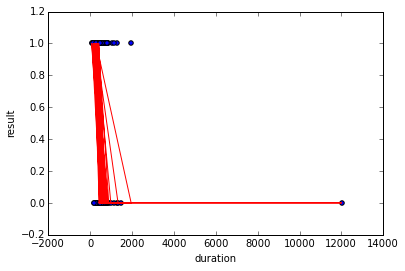

In [30]:
# plot the class predictions
plt.scatter(model_base.duration, model_base.result)
plt.plot(model_base.duration, model_base.result_pred_class, color='red')
plt.xlabel('duration')
plt.ylabel('result')

In [23]:
# manually add the intercept
#add a constant term for our Logistic Regression. 
#The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.
meta_log_reg['intercept'] = 1.0